In [1]:
import pickle
import json
from collections import defaultdict, Counter
from unidecode import unidecode

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Load indexes etc

In [14]:
dataset_info = pd.read_csv('datasets-2017-06-27-15-14.csv', sep=';')
datasets = list(dataset_info.id)
datasets_set = set(datasets)
datasets_index = {dataset: i for i, dataset in enumerate(datasets)}
n_datasets = len(datasets)
id2slug = {r[1]: r[3] for r in dataset_info.itertuples()}
slug2id = {r[3]: r[1] for r in dataset_info.itertuples()}

keywords = pickle.load(open('keywords_list.pickle', 'rb'))
keywords_set = set(keywords)
keywords_index = {keyword: i for i, keyword in enumerate(keywords)}
n_keywords = len(keywords)

# Load logs

In [3]:
with open('visits_by_day2.json', 'r') as f:
    visits_by_day = json.load(f)

In [4]:
days = sorted(visits_by_day.keys())
days_index = {day: i for i, day in enumerate(days)}
n_days = len(days)

# Keyword list

In [5]:
keyword_count = defaultdict(int)
for day in days:
    visits = visits_by_day[day]    
    for visit in visits:
        for kind, value in visit:
            if (kind == 'keyword'):
                keyword_count[value] += 1

In [6]:
len(keyword_count)

236863

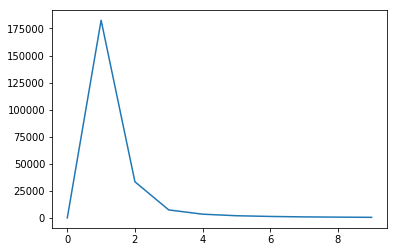

In [7]:
counts = [couple[1] for couple in keyword_count.items()]
count_histogram = np.zeros((max(counts) + 1))
for count in counts:
    count_histogram[count] += 1
    
plt.plot(count_histogram[:10])


In [8]:
sum(count_histogram[4:])

13482.0

In [9]:
# Execute this only once
#keywords = [keyword for keyword, count in keyword_count.items() if (count >= 4) and (len(keyword)>=3)]
#pickle.dump(keywords, open('keywords_list.pickle', 'wb'))

In [10]:
keyword_count_np = np.array([keyword_count[k] for k in keywords])
with open('keyword_count.pickle', 'wb') as f:
    pickle.dump(keyword_count_np, f)

In [11]:
Counter(keyword_count).most_common(10)

[('sirene', 4456),
 ('siren', 1417),
 ('finess', 1387),
 ('elections', 1342),
 ('communes', 1025),
 ('election', 1013),
 ('extraction finess', 933),
 ('insee', 802),
 ('paris', 722),
 ('legislatives', 664)]

In [12]:
sum([v for k, v in keyword_count.items()]), sum([keyword_count[k] for k in keywords])

(492273, 202015)

# Datasets

In [15]:
dataset_count = defaultdict(int)
for day in days:
    visits = visits_by_day[day]    
    for visit in visits:
        for kind, value in visit:
            if (kind == 'id'):
                dataset_count[value] += 1

In [16]:
len(dataset_count)

23931

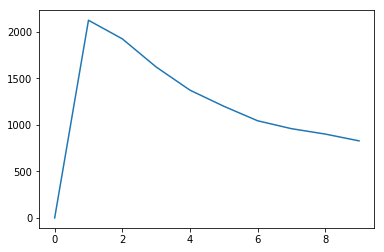

In [17]:
counts = [couple[1] for couple in dataset_count.items()]
count_histogram = np.zeros((max(counts) + 1))
for count in counts:
    count_histogram[count] += 1
    
plt.plot(count_histogram[:10])

In [18]:
sum(count_histogram[4:])

18261.0

In [19]:
dataset_count_np = np.array([dataset_count[d] for d in datasets])
with open('dataset_count.pickle', 'wb') as f:
    pickle.dump(dataset_count_np, f)

In [20]:
for ident, c in Counter(dataset_count).most_common(10):
    print('{}\t{}'.format(c, id2slug[ident]))

78236	liste-publique-des-organismes-de-formation-l-6351-7-1-du-code-du-travail
74697	base-sirene-des-entreprises-et-de-leurs-etablissements-siren-siret
39114	base-officielle-des-codes-postaux
26701	correspondance-entre-les-codes-postaux-et-codes-insee-des-communes-francaises
22205	service-public-fr-guide-vos-droits-et-demarches-particuliers
17686	associations-reconnues-d-utilite-publique
17651	decoupage-administratif-communal-francais-issu-d-openstreetmap
16936	election-presidentielle-des-23-avril-et-7-mai-2017-resultats-du-1er-tour
16337	countours-des-circonscriptions-des-legislatives-nd
13874	elections-legislatives-des-11-et-18-juin-2017-resultats-du-2nd-tour-par-communes


# Temporal profile, keywords

In [21]:
keyword_profiles = np.zeros((n_days, n_keywords))
for day in days:
    visits = visits_by_day[day]
    day_index = days_index[day]
    
    for visit in visits:
        for kind, value in visit:
            if (kind == 'keyword') and (value in keywords_set):
                keyword_index = keywords_index[value]
                keyword_profiles[day_index, keyword_index] += 1

In [22]:
with open('keyword_profiles.pickle', 'wb') as f:
    pickle.dump(keyword_profiles, f)

In [23]:
def plot_keyword_profile(keyword):
    keyword_index = keywords_index[keyword]
    
    profile = keyword_profiles[:, keyword_index]
    
    plt.plot(profile)

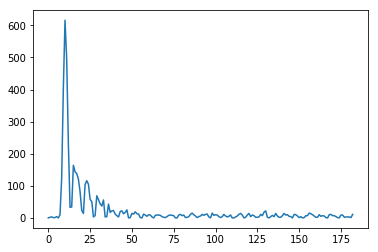

In [24]:
plot_keyword_profile('sirene')

# Temporal profile, datasets

In [25]:
dataset_profiles = np.zeros((n_days, n_datasets))
for day in days:
    visits = visits_by_day[day]
    day_index = days_index[day]
    
    for visit in visits:
        for kind, value in visit:
            if (kind == 'id') and (value in datasets_set):
                dataset_index = datasets_index[value]
                dataset_profiles[day_index, dataset_index] += 1

In [26]:
with open('dataset_profiles.pickle', 'wb') as f:
    pickle.dump(dataset_profiles, f)

In [27]:
def plot_dataset_profile(slug):
    ident = slug2id[slug]
    dataset_index = datasets_index[ident]
    
    profile = dataset_profiles[:, dataset_index]
    
    plt.plot(profile)

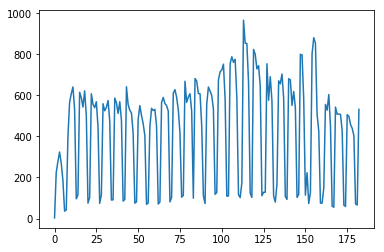

In [28]:
plot_dataset_profile('liste-publique-des-organismes-de-formation-l-6351-7-1-du-code-du-travail')

# Dataset, dataset

In [29]:
# Adjacency list representation
adj_datasets = [defaultdict(int) for i in range(n_datasets)]
for day in days:
    for visit in visits_by_day[day]:
        ids = [ident for kind, ident in visit if kind == 'id']
        ids = list(set(ids))
        for d1 in ids:
            index1 = datasets_index[d1]
            for d2 in ids:
                index2 = datasets_index[d2]
                adj_datasets[index1][index2] += 1
adj_datasets = [dict(adjacency_list) for adjacency_list in adj_datasets]
pickle.dump(adj_datasets, open('dataset_dataset_adjacency_list.pickle', 'wb'))

In [30]:
sum([len(l) for l in adj_datasets]) / (n_datasets * n_datasets)

0.028480818960466583

# Keyword, keyword

In [ ]:
# Matrix representation (not adapted to sparse matrices)
kk = np.zeros((n_keywords, n_keywords), dtype=np.uint16)
for idVisit, searches in searches_by_visit.items():
    visit_keywords = list(set([search['keyword'] for search in searches]))
    visit_keywords_kept = [k for k in visit_keywords if k in keywords_set]
    for k1 in visit_keywords_kept:
        index1 = keywords_index[k1]
        for k2 in visit_keywords_kept:
            index2 = keywords_index[k2]
            if kk[index1, index2] == 65535:
                print("overflow")
            kk[index1, index2] += 1
kk.max(), float((kk>0).sum())/(n_keywords*n_keywords)

In [31]:
# Adjacency list representation
adj_keywords = [defaultdict(int) for i in range(n_keywords)]
for day in days:
    for visit in visits_by_day[day]:
        ks = [k for kind, k in visit if (kind == 'keyword') and (k in keywords_set)]
        ks = list(set(ks))
        for d1 in ks:
            index1 = keywords_index[d1]
            for d2 in ks:
                index2 = keywords_index[d2]
                adj_keywords[index1][index2] += 1
adj_keywords = [dict(adjacency_list) for adjacency_list in adj_keywords]
pickle.dump(adj_keywords, open('keyword_keyword_adjacency_list.pickle', 'wb'))

In [32]:
sum([len(l) for l in adj_keywords]) / (n_keywords * n_keywords)

0.00777783057115581

# Keyword, dataset

In [33]:
# Adjacency list representation
adj_keyword_dataset = [defaultdict(int) for i in range(n_keywords)]
for day in days:
    for visit in visits_by_day[day]:
        current_keyword_index = None
        for kind, value in visit:
            if kind == 'keyword':
                if value in keywords_set:
                    current_keyword_index = keywords_index[value]
            elif kind == 'id':
                if current_keyword_index:
                    dataset_index = datasets_index[value]
                    adj_keyword_dataset[current_keyword_index][dataset_index] += 1
            else:
                raise ValueError(kind)
adj_keyword_dataset = [dict(adjacency_list) for adjacency_list in adj_keyword_dataset]
pickle.dump(adj_keyword_dataset, open('keyword_dataset_adjacency_list.pickle', 'wb'))

In [34]:
sum([len(l) for l in adj_keyword_dataset]), sum([len(l) for l in adj_keyword_dataset]) / (n_keywords * n_datasets)

(274893, 0.0008231586555968243)